In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns


# CSV laden
df = pd.read_csv(r"C:\Users\valen\OneDrive\Dokumente\01_Studium\9\Probabilistic ML\Local\player_stats_clean.csv")
df.columns = df.columns.str.strip()

# Featureliste
features = [
"SCA90","GCA90","KP","PPA","1/3","CrsPA","PrgP","Int","Clr",
    "Touches","TeamSuccess+/-90","TeamSuccess(xG)xG+/-90","StandardSh/90","StandardSoT/90"
]

# Featurematrix
X = df[features].replace([np.inf, -np.inf], np.nan)

print("Features:", features)
print("Shape:", X.shape)


Features: ['SCA90', 'GCA90', 'KP', 'PPA', '1/3', 'CrsPA', 'PrgP', 'Int', 'Clr', 'Touches', 'TeamSuccess+/-90', 'TeamSuccess(xG)xG+/-90', 'StandardSh/90', 'StandardSoT/90']
Shape: (359, 14)


In [2]:
X = X.fillna(X.mean())

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

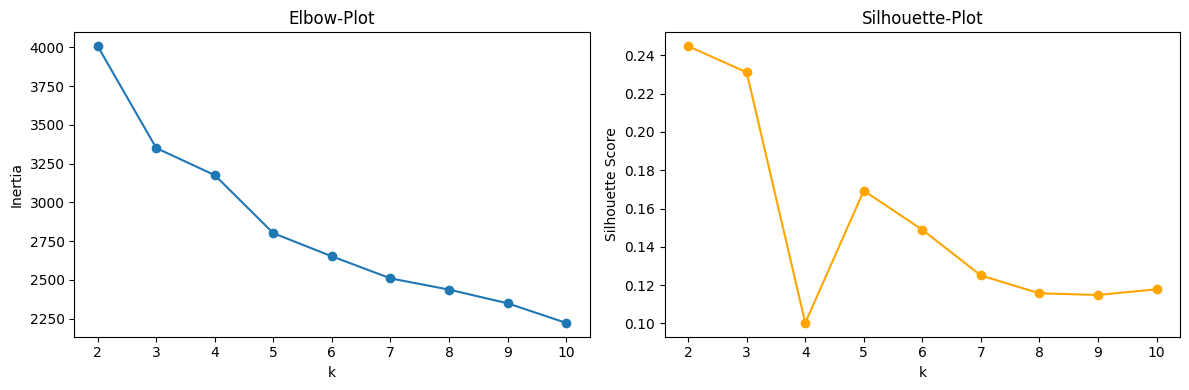

In [4]:
# Elbow & Silhouette
inertias = []
sil_scores = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plotten
plt.figure(figsize=(12, 4))

# Elbow
plt.subplot(1, 2, 1)
plt.plot(K, inertias, '-o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow-Plot")

# Silhouette
plt.subplot(1, 2, 2)
plt.plot(K, sil_scores, '-o', color='orange')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette-Plot")

plt.tight_layout()
plt.show()


In [9]:
# Aus der Grafik k auswählen
k_opt = 5
kmeans = KMeans(n_clusters=k_opt, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)


In [10]:
# Mittlere Feature-Werte pro Cluster (auf unskalierten Daten)
centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=features
)
centers.index.name = "Cluster"
print(centers)


            SCA90     GCA90        KP       PPA        1/3     CrsPA  \
Cluster                                                                
0        1.241438  0.074521  1.082192  0.801370   3.321918  0.301370   
1        1.349014  0.094507  1.521127  1.380282  13.366197  0.253521   
2        3.482976  0.297619  3.738095  2.357143   5.178571  0.500000   
3        2.449444  0.152222  5.222222  4.083333  33.416667  1.000000   
4        4.279545  0.488182  8.545455  8.409091  10.227273  3.181818   

              PrgP       Int        Clr     Touches  TeamSuccess+/-90  \
Cluster                                                                 
0         4.280822  0.897260   3.993151  104.089041         -0.592945   
1        13.464789  3.943662  12.281690  235.169014         -0.160563   
2         7.595238  0.821429   1.952381  114.059524          0.299405   
3        32.500000  3.888889  10.638889  406.055556          0.568056   
4        18.409091  2.318182   3.863636  230.545455      

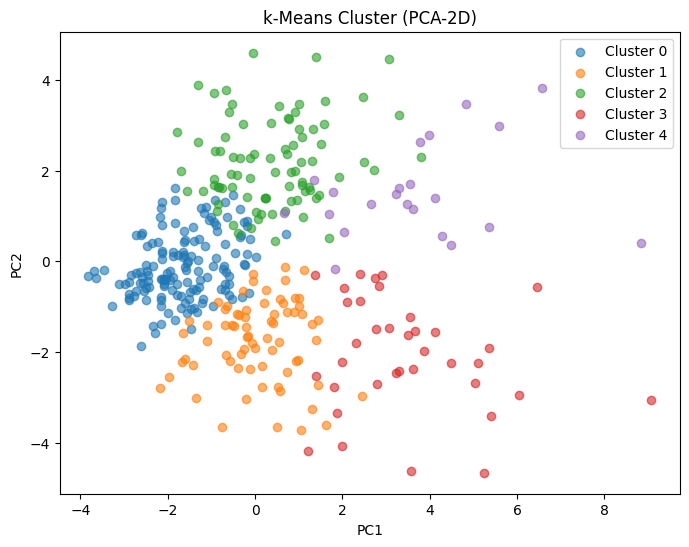

In [11]:
# PCA plotten
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for c in range(k_opt):
    mask = df['Cluster']==c
    plt.scatter(
        X_pca[mask,0], X_pca[mask,1],
        label=f"Cluster {c}", alpha=0.6
    )
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.title("k-Means Cluster (PCA-2D)")
plt.show()


PrimaryPosGrp  DF  FW  GK  MF
Cluster                      
0              52  28  28  38
1              52   0   0  19
2               7  46   0  31
3              19   1   0  16
4               8  10   0   4


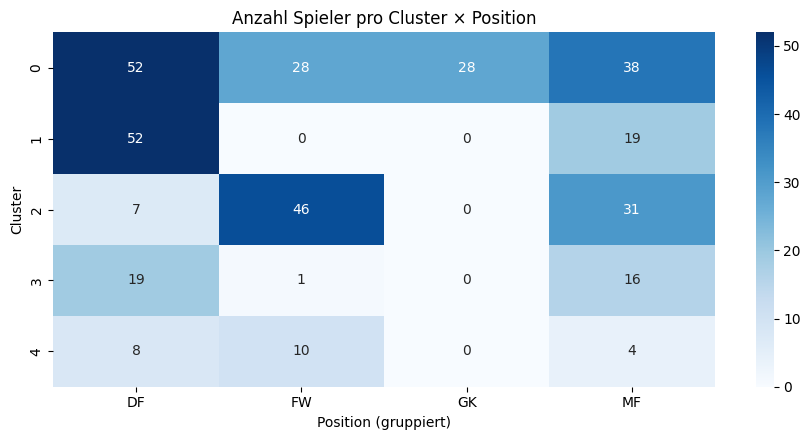

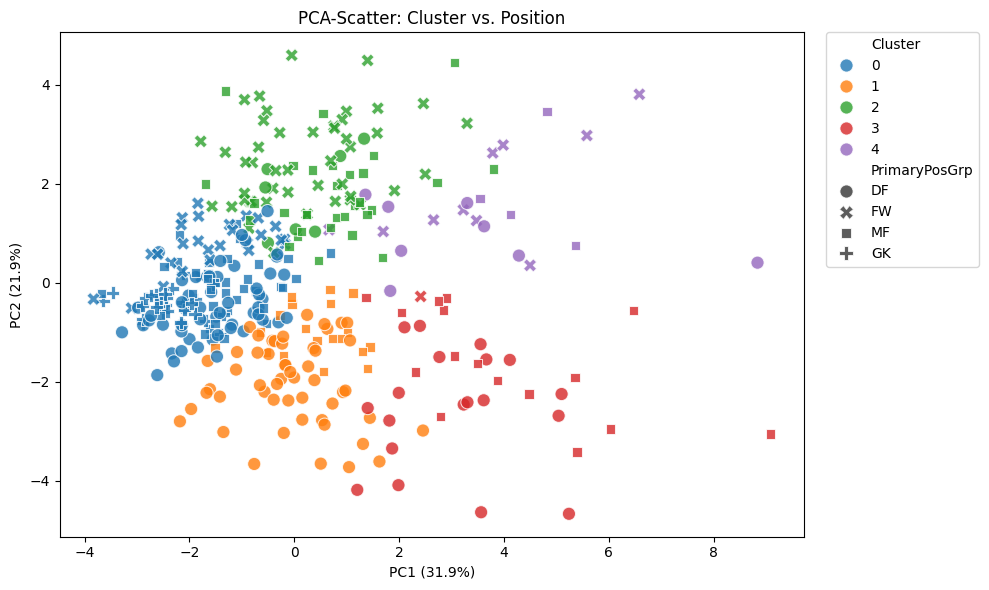

In [14]:
# ===== Daten genauer anschauen
# Primär-Position aus 'Pos' ableiten (vor dem Slash)
df['PrimaryPos'] = (
    df['Pos']
    .astype(str)        # alles in Strings umwandeln
    .str.split('/', n=1)  # am ersten Slash teilen
    .str[0]             # erstes Element nehmen
    .str.strip()        # Leerzeichen entfernen
)


# Optional, zu viele Positionskürzel zusammenfassen:
top_n = 8
top_pos = df['PrimaryPos'].value_counts().nlargest(top_n).index
df['PrimaryPosGrp'] = df['PrimaryPos'].where(df['PrimaryPos'].isin(top_pos), 'Other')

# Kontingenztabelle Cluster × Position
ct = pd.crosstab(df['Cluster'], df['PrimaryPosGrp'])
print(ct)

# Heatmap der Verteilung
plt.figure(figsize=(9, 4.5))
sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Cluster")
plt.xlabel("Position (gruppiert)")
plt.title("Anzahl Spieler pro Cluster × Position")
plt.tight_layout()
plt.show()

# PCA für 2D-Plot 
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X_scaled)

expl = pca.explained_variance_ratio_ * 100

df['PC1'] = pcs[:, 0]
df['PC2'] = pcs[:, 1]

# Scatter: Farbe = Cluster, Marker = Position
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='PC1', y='PC2',
    hue='Cluster',          # Farbe nach Cluster
    style='PrimaryPosGrp',  # Marker nach (gruppierter) Position
    palette='tab10',
    s=90, alpha=0.8
)
plt.title("PCA-Scatter: Cluster vs. Position")
plt.xlabel(f"PC1 ({expl[0]:.1f}%)")
plt.ylabel(f"PC2 ({expl[1]:.1f}%)")
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


In [15]:
# Grenzwerte und Namen je Cluster und PC
pca_df = pd.DataFrame(pcs, columns=['PC1', 'PC2'], index=df.index)
pca_df['Cluster'] = df['Cluster']
pca_df['Player'] = df['Player']

# Spieler mit extremen PC1-Werten pro Cluster
extreme_pc1 = pca_df.loc[pca_df.groupby('Cluster')['PC1'].idxmax()]
extreme_pc1_min = pca_df.loc[pca_df.groupby('Cluster')['PC1'].idxmin()]

# Spieler mit extremen PC2-Werten pro Cluster
extreme_pc2 = pca_df.loc[pca_df.groupby('Cluster')['PC2'].idxmax()]
extreme_pc2_min = pca_df.loc[pca_df.groupby('Cluster')['PC2'].idxmin()]

print(">> Spieler mit höchstem PC1 pro Cluster")
print(extreme_pc1[['Player', 'PC1', 'PC2']])

print("\n>> Spieler mit niedrigstem PC1 pro Cluster")
print(extreme_pc1_min[['Player', 'PC1', 'PC2']])

print("\n>> Spieler mit höchstem PC2 pro Cluster")
print(extreme_pc2[['Player', 'PC1', 'PC2']])

print("\n>> Spieler mit niedrigstem PC2 pro Cluster")
print(extreme_pc2_min[['Player', 'PC1', 'PC2']])


>> Spieler mit höchstem PC1 pro Cluster
              Player       PC1       PC2
254  Nicolae Stanciu  0.697715  0.600738
93      Fabian Schär  2.456395 -2.984238
177  Kevin De Bruyne  3.805122  2.301626
329       Toni Kroos  9.081010 -3.055393
147   Joshua Kimmich  8.839558  0.407845

>> Spieler mit niedrigstem PC1 pro Cluster
                  Player       PC1       PC2
351  Zuriko Davitashvili -3.830913 -0.326554
119         Guram Kashia -2.181506 -2.798141
185          Kwadwo Duah -1.784932  2.859313
150          John Stones  1.201925 -4.182528
99       Federico Chiesa  0.662199  1.071303

>> Spieler mit höchstem PC2 pro Cluster
                 Player       PC1       PC2
295  Robert Lewandowski -1.838855  1.606909
121    Hakan Çalhanoğlu  0.683141 -0.137103
28         Ante Budimir -0.048287  4.598951
277          Phil Foden  2.411603 -0.274683
190        Lamine Yamal  6.584670  3.810260

>> Spieler mit niedrigstem PC2 pro Cluster
              Player       PC1       PC2
306  Saba 

In [17]:
# Ausgabe aller Spieler

# DataFrame mit Spieler, Position, PC1, PC2 und Cluster
pca_table = pd.DataFrame(pcs, columns=['PC1', 'PC2'], index=df.index)
pca_table['Player'] = df['Player']          
pca_table['Position'] = df['PrimaryPosGrp'] 
pca_table['Cluster'] = df['Cluster']

# Nach Cluster, dann PC1 sortieren
pca_table = pca_table.sort_values(by=['Cluster', 'PC1'], ascending=[True, True])

# Ausgabe
print(pca_table.to_string(index=False))

# Optional: als CSV exportieren
# pca_table.to_csv("players_pca_clusters_positions.csv", index=False)



      PC1       PC2                    Player Position  Cluster
-3.830913 -0.326554       Zuriko Davitashvili       FW        0
-3.678465 -0.220121             Ryan Christie       MF        0
-3.650283 -0.360586            Altay Bayındır       GK        0
-3.462916 -0.202300              Andriy Lunin       GK        0
-3.286634 -0.998894            Kieran Tierney       DF        0
-3.105696 -0.510397             David Doudera       FW        0
-2.978915 -0.500914          Gianluca Mancini       DF        0
-2.898197 -0.456006          Thomas Strakosha       GK        0
-2.886971 -0.810916                Angus Gunn       GK        0
-2.885687 -0.732271      Giorgi Mamardashvili       GK        0
-2.883380 -0.857575                Ezri Konsa       DF        0
-2.834895 -0.310053         Wojciech Szczęsny       GK        0
-2.771986 -0.759059               Iván Balliu       DF        0
-2.731752 -0.665453          Paweł Dawidowicz       DF        0
-2.731541  0.580828                 Rey 